In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Data Preparation

In [2]:
df = pd.read_csv('../../Datasets/telco/telco.csv');
df.columns = df.columns.str.lower()
df.head(3)

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,...,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes


In [3]:
df.dtypes

customerid           object
gender               object
seniorcitizen         int64
partner              object
dependents           object
tenure                int64
phoneservice         object
multiplelines        object
internetservice      object
onlinesecurity       object
onlinebackup         object
deviceprotection     object
techsupport          object
streamingtv          object
streamingmovies      object
contract             object
paperlessbilling     object
paymentmethod        object
monthlycharges      float64
totalcharges         object
churn                object
dtype: object

In [4]:
categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)
for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

# convert to numeric because totalcharges is of type object
# ignore errors with errors='coerce'
df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
# fill NaN with zeros
df.totalcharges = df.totalcharges.fillna(0)
# convert target to zeros and ones
df['churn'] = (df['churn'] == 'yes').astype(int)
df.head(3)

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,...,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
0,7590-vhveg,female,0,yes,no,1,no,no_phone_service,dsl,no,...,no,no,no,no,month-to-month,yes,electronic_check,29.85,29.85,0
1,5575-gnvde,male,0,no,no,34,yes,no,dsl,yes,...,yes,no,no,no,one_year,no,mailed_check,56.95,1889.50,0
2,3668-qpybk,male,0,no,no,2,yes,no,dsl,yes,...,no,no,no,no,month-to-month,yes,mailed_check,53.85,108.15,1


In [5]:
# model
from sklearn.linear_model import LogisticRegression

# for calculating the accuracy
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# for splitting the data
from sklearn.model_selection import train_test_split

# 60, 20, 20 splitting
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
len(df_full_train), len(df_test)

df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_full_train = df_full_train.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

full_train_y = df_full_train.churn.values
train_y = df_train.churn.values
val_y = df_val.churn.values
test_y = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']

In [6]:
len(df_val), len(df_test), len(df_train)

(1409, 1409, 4225)

### EDA

In [7]:
numerical_variables = ['tenure', 'monthlycharges', 'totalcharges']
categorical_variables = [column for column in df_full_train.columns if column not in numerical_variables and column != 'churn' and column != 'customerid']

# get churn rate by getting the number of 1s / size 
global_churn_rate = df_full_train.churn.mean()
global_churn_rate.round(2) # must be equal to normalized value of 1

0.27

In [8]:
df[categorical_variables].nunique()

gender              2
seniorcitizen       2
partner             2
dependents          2
phoneservice        2
multiplelines       3
internetservice     3
onlinesecurity      3
onlinebackup        3
deviceprotection    3
techsupport         3
streamingtv         3
streamingmovies     3
contract            3
paperlessbilling    2
paymentmethod       4
dtype: int64

In [9]:
df_full_train.isnull().sum()

customerid          0
gender              0
seniorcitizen       0
partner             0
dependents          0
tenure              0
phoneservice        0
multiplelines       0
internetservice     0
onlinesecurity      0
onlinebackup        0
deviceprotection    0
techsupport         0
streamingtv         0
streamingmovies     0
contract            0
paperlessbilling    0
paymentmethod       0
monthlycharges      0
totalcharges        0
churn               0
dtype: int64

In [10]:
from IPython.display import display

for column in categorical_variables:
    print(f"Processing column: {column}")
    df_group = df_full_train.groupby(column).churn.agg(['mean', 'count'])
    df_group['diff'] = df_group['mean'] - global_churn_rate
    df_group['risk'] = df_group['mean'] / global_churn_rate
    display(df_group)
    print('\n\n')

Processing column: gender


,mean,count,diff,risk
gender,,,,
female,0.276824,2796,0.006856,1.025396
male,0.263214,2838,-0.006755,0.974980





Processing column: seniorcitizen


,mean,count,diff,risk
seniorcitizen,,,,
0,0.242270,4722,-0.027698,0.897403
1,0.413377,912,0.143409,1.531208





Processing column: partner


,mean,count,diff,risk
partner,,,,
no,0.329809,2932,0.059841,1.221659
yes,0.205033,2702,-0.064935,0.759472





Processing column: dependents


,mean,count,diff,risk
dependents,,,,
no,0.313760,3968,0.043792,1.162212
yes,0.165666,1666,-0.104302,0.613651





Processing column: phoneservice


,mean,count,diff,risk
phoneservice,,,,
no,0.241316,547,-0.028652,0.893870
yes,0.273049,5087,0.003081,1.011412





Processing column: multiplelines


,mean,count,diff,risk
multiplelines,,,,
no,0.257407,2700,-0.012561,0.953474
no_phone_service,0.241316,547,-0.028652,0.893870
yes,0.290742,2387,0.020773,1.076948





Processing column: internetservice


,mean,count,diff,risk
internetservice,,,,
dsl,0.192347,1934,-0.077621,0.712482
fiber_optic,0.425171,2479,0.155203,1.574895
no,0.077805,1221,-0.192163,0.288201





Processing column: onlinesecurity


,mean,count,diff,risk
onlinesecurity,,,,
no,0.420921,2801,0.150953,1.559152
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.153226,1612,-0.116742,0.567570





Processing column: onlinebackup


,mean,count,diff,risk
onlinebackup,,,,
no,0.404323,2498,0.134355,1.497672
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.217232,1915,-0.052736,0.804660





Processing column: deviceprotection


,mean,count,diff,risk
deviceprotection,,,,
no,0.395875,2473,0.125907,1.466379
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.230412,1940,-0.039556,0.853480





Processing column: techsupport


,mean,count,diff,risk
techsupport,,,,
no,0.418914,2781,0.148946,1.551717
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.159926,1632,-0.110042,0.592390





Processing column: streamingtv


,mean,count,diff,risk
streamingtv,,,,
no,0.342832,2246,0.072864,1.269897
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.302723,2167,0.032755,1.121328





Processing column: streamingmovies


,mean,count,diff,risk
streamingmovies,,,,
no,0.338906,2213,0.068938,1.255358
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.307273,2200,0.037305,1.138182





Processing column: contract


,mean,count,diff,risk
contract,,,,
month-to-month,0.431701,3104,0.161733,1.599082
one_year,0.120573,1186,-0.149395,0.446621
two_year,0.028274,1344,-0.241694,0.104730





Processing column: paperlessbilling


,mean,count,diff,risk
paperlessbilling,,,,
no,0.172071,2313,-0.097897,0.637375
yes,0.338151,3321,0.068183,1.252560





Processing column: paymentmethod


,mean,count,diff,risk
paymentmethod,,,,
bank_transfer_(automatic),0.168171,1219,-0.101797,0.622928
credit_card_(automatic),0.164339,1217,-0.105630,0.608733
electronic_check,0.455890,1893,0.185922,1.688682
mailed_check,0.193870,1305,-0.076098,0.718121


In [11]:
# import mutual_info_score from sklearn.metrics
from sklearn.metrics import mutual_info_score

# apply mutual_info_score to the categorical variables
mutual_info = {}
for column in categorical_variables:
    mutual_info[column] = mutual_info_score(df_full_train.churn, df_full_train[column])
# sort in descending order by value
sorted(mutual_info.items(), key=lambda x : x[1], reverse=True)

# def mutual_info_churn_score(series):
#     return mutual_info_score(df_full_train.churn, series)

# mi = df_full_train[categorical_variables].apply(mutual_info_churn_score).sort_values(ascending=False)
# mi

[('contract', 0.0983203874041556),
 ('onlinesecurity', 0.06308524972985574),
 ('techsupport', 0.06103245991777444),
 ('internetservice', 0.055867945893496467),
 ('onlinebackup', 0.0469234640537918),
 ('deviceprotection', 0.04345286925268559),
 ('paymentmethod', 0.043210027531582915),
 ('streamingtv', 0.03185333110086085),
 ('streamingmovies', 0.03158089669519908),
 ('paperlessbilling', 0.01758882715925275),
 ('dependents', 0.012345815445534689),
 ('partner', 0.009967689095399745),
 ('seniorcitizen', 0.009410216144208144),
 ('multiplelines', 0.0008574478744731856),
 ('phoneservice', 0.00022871269738296285),
 ('gender', 0.0001174846211139946)]

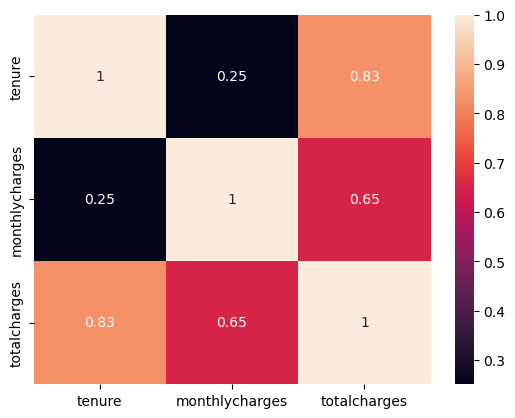

In [12]:
corr_matrix = df_full_train[numerical_variables].corr()
sns.heatmap(corr_matrix, annot=True)
plt.show()

### One-hot Encoding

In [13]:
# one hot encoding from sklearn
from sklearn.feature_extraction import DictVectorizer

train_dicts = df_train[categorical_variables + numerical_variables].to_dict(orient='records')
dv = DictVectorizer(sparse=False)
# dv.fit_transform(X) fits and immediately transforms the DictVectorizer to a matrix of 0s and 1s
dv.fit(train_dicts)
X_train = dv.transform(train_dicts)
# val
val_dicts = df_val[categorical_variables + numerical_variables].to_dict(orient='records')
X_val = dv.transform(val_dicts)

### Model

In [14]:
model = LogisticRegression(max_iter=3000)
model.fit(X_train, train_y)

LogisticRegression(max_iter=3000)

In [15]:
y_pred = model.predict_proba(X_val)[:,1]
churn_decision = (y_pred >= 0.5)

df_pred = pd.DataFrame()
df_pred['probability'] = y_pred
df_pred['prediction'] = churn_decision.astype(int)
df_pred['actual_val'] = val_y
df_pred['correct'] = (df_pred.prediction == df_pred.actual_val)
df_pred

,probability,prediction,actual_val,correct
0,0.006629,0,0,True
1,0.204776,0,0,True
2,0.217348,0,0,True
3,0.564584,1,1,True
4,0.218046,0,0,True
...,...,...,...,...
1404,0.293219,0,0,True
1405,0.041337,0,1,False
1406,0.151561,0,0,True
1407,0.788574,1,1,True


In [16]:
df_pred.correct.mean()

0.8041163946061036

In [17]:
# # convert dataframe to dictionaries to allow dictvectorizer transform for one hot encoding
# dicts_full_train = df_full_train[categorical_variables + numerical_variables].to_dict(orient='records')
# dicts_test_train = df_test[categorical_variables + numerical_variables].to_dict(orient='records')
# X_full_train = dv.transform(dicts_full_train)
# X_test = dv.transform(dicts_test_train)

# # use liblinear solver (good for small datasets)
# full_model = LogisticRegression(solver='liblinear')
# full_model.fit(X_full_train, full_train_y)

# # predict probability with predict_proba
# full_prediction = (full_model.predict_proba(X_test)[:,1] >= 0.5)

# (full_prediction == test_y).mean()

# Lecture 4.2: Accuracy and Dummy Model

Accuracy measures the fraction of correct predictions. Specifically, it is the number of correct predictions divided by the total number of predictions.

In this problem accuracy can not tell us how good is the model because the dataset is unbalanced, which means that there are more instances from one category than the other. This is also known as **class imbalance**.

In [18]:
pi_val = np.array([df_pred.correct.sum(), len(val_y) - df_pred.correct.sum()])

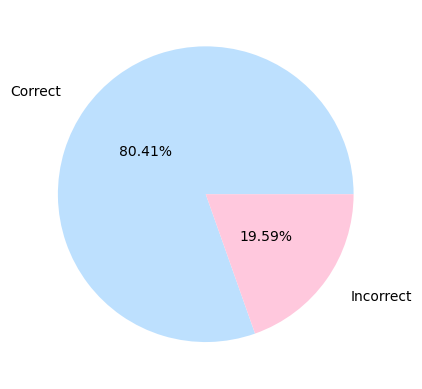

In [19]:
plt.pie(pi_val, labels=["Correct", "Incorrect"], colors=['#bde0fe', '#ffc8dd'], autopct='%1.2f%%', pctdistance=0.5, labeldistance=1.2)
plt.show()

This can help us determine which threshold is best.

In [20]:
from sklearn.metrics import accuracy_score

threshold = np.linspace(0, 1, 21)
results = {}
for thd in threshold:
    churn_decision = (y_pred >= thd)
    results[thd.round(2)] = accuracy_score(churn_decision.astype(int), val_y)

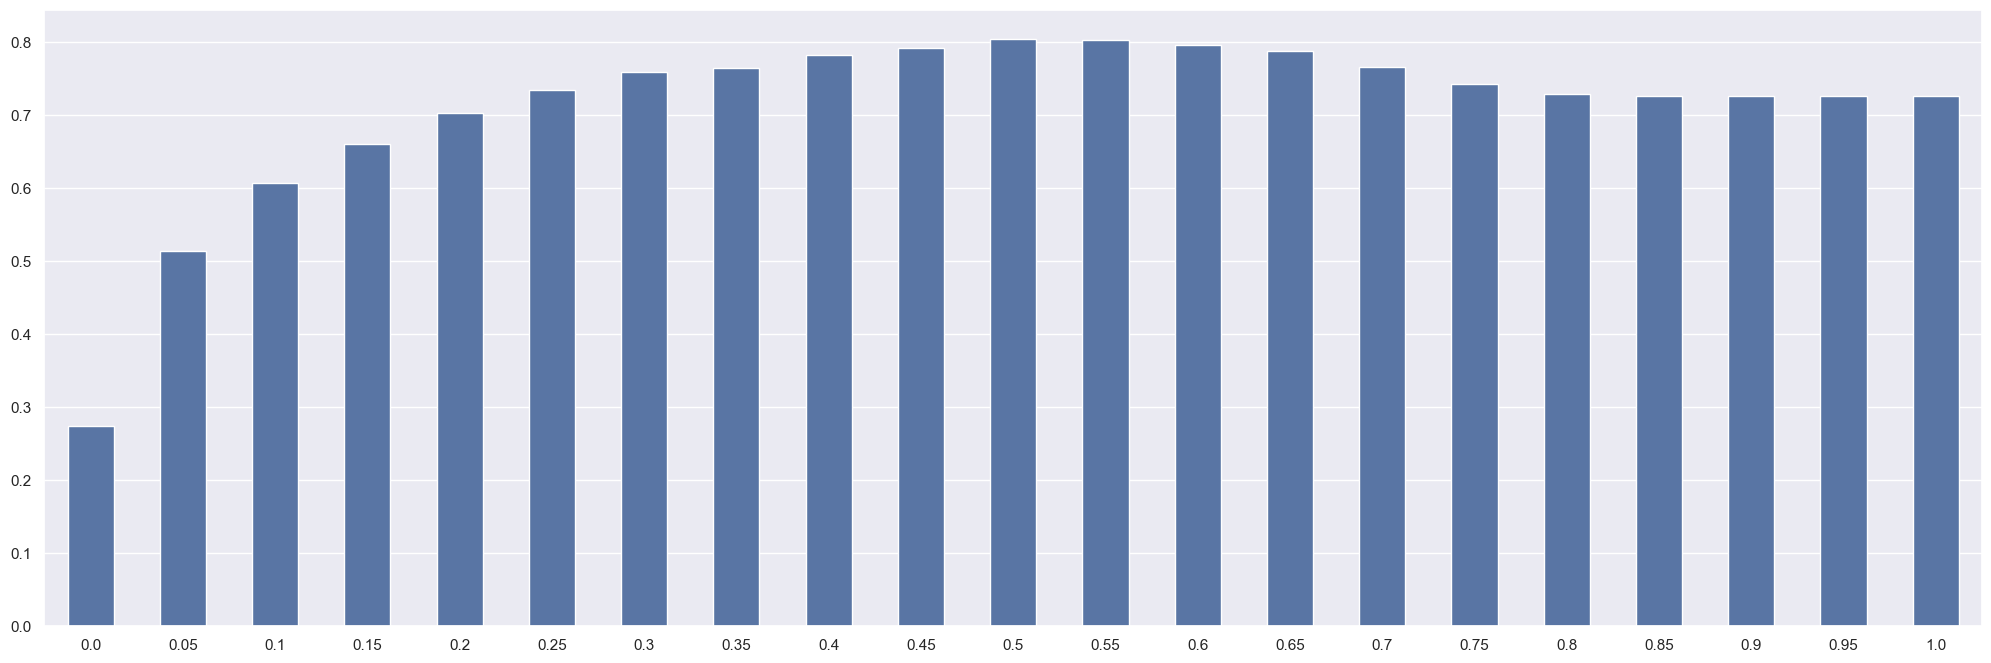

In [24]:
width = 25
height = 8
sns.set(rc = {'figure.figsize':(width, height)})
sns.barplot(results, width=0.5)
plt.show()

In [22]:
from collections import Counter

Counter(y_pred >= 1.0)

Counter({False: 1409})

In [49]:
df_pred.correct.value_counts(normalize=True)

correct
True     0.804116
False    0.195884
Name: proportion, dtype: float64

**NOTE**: Accuracy is not a reliable metric when it comes to imbalanced datasets as it can often be misleading.

# Lecture 4.3: Confusion Table

In this specific churn problem, there are four(4) possible results:
```
True Positve = True Prediction + True Actual Result
True Negative = False Prediction + False Actual Result
False Positive = True Prediction + False Actual Result
False Negative = False Prediction + True Actual Result
```

In [26]:
df_pred.head().T

,0,1,2,3,4
probability,0.006629,0.204776,0.217348,0.564584,0.218046
prediction,0,0,0,1,0
actual_val,0,0,0,1,0
correct,True,True,True,True,True


In [67]:
# false positives
fp = Counter(df_pred[(df_pred['prediction'] == 1) & (df_pred['actual_val'] == 0)].correct)[0]
# false negatives
fn = Counter(df_pred[(df_pred['prediction'] == 0) & (df_pred['actual_val'] == 1)].correct)[0]
# true positives 
tp = Counter(df_pred[(df_pred['prediction'] == 1) & (df_pred['actual_val'] == 1)].correct)[1]
# true negatives
tn = Counter(df_pred[(df_pred['prediction'] == 0) & (df_pred['actual_val'] == 0)].correct)[1]

In [68]:
assert (tp + tn) / len(df_pred) == df_pred.correct.mean()

In [69]:
print(f"False Positive: {fp}\nFalse Negative: {fn}\nTotal Errors: {fp+fn}")

False Positive: 102
False Negative: 174
Total Errors: 276


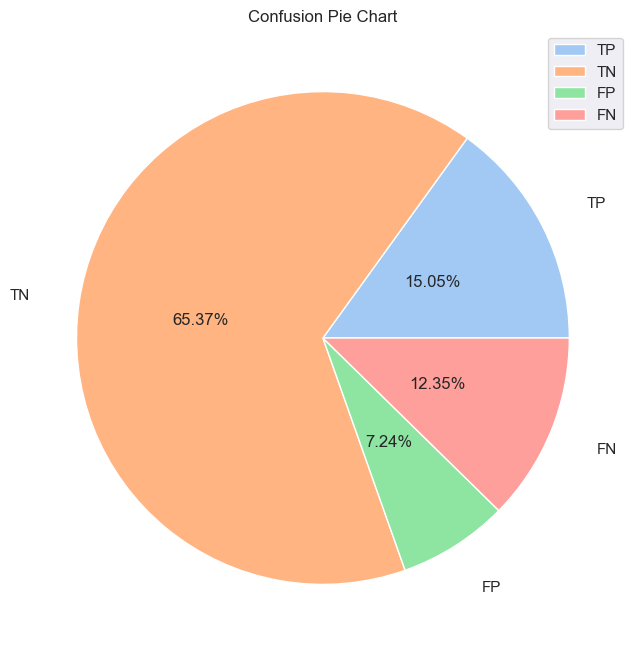

In [91]:
c_palette = sns.color_palette('pastel')
tf_val = [tp, tn, fp, fn]
plt.pie(tf_val, labels=["TP", "TN", "FP", "FN"], colors=c_palette, autopct='%1.2f%%', pctdistance=0.5, labeldistance=1.2)
plt.title('Confusion Pie Chart')
plt.legend()
plt.show()

In [89]:
from sklearn.metrics import confusion_matrix

confusion_matrix(df_pred.actual_val, df_pred.prediction)

array([[921, 102],
       [174, 212]], dtype=int64)

# Lecture 4.4: Precision and Recall

useful, informative blog about confusion matrix: https://towardsdatascience.com/understanding-confusion-matrix-a9ad42dcfd62


In [109]:
# Precision: fraction of positive predictions that is correct.
# key: we look at our predictions
# precision = tp / (tp + fp)
precision = tp / (tp + fp)
np.round(precision, 2)

0.68

In [110]:
# Recall: fraction of correct predictions among the positive class.(churned customers)
# key: we look at the actual result
# recall = tp / (tp + fn)
recall = tp / (tp + fn)
np.round(recall, 2)

0.55

The result of *recall* is a prime example of accuracy being a misleading metric. Notice that only 55% of customers who actually churned were correctly identified. We don't really care about non-churners because we will not do appropriate measures for them. **The problem is to solve who might churn to prevent it**.

As per the *precision*, it tells us the mistakes we've made when predicting *positive* and allow us to determine wasted cost(in this case giving promotional offers to a predicted churning customer even though they did not actually churn).

# Lecture 4.5: ROC Curves

**False positive rate**: fraction of false positives in the positive predictions.\
**True positive rate**: fraction of true positives among the total number of positive examples (same as recall)

In [114]:
tpr = tp / (tp + fn)
fpr = fp / (fp + tn)
print(F"True positive rate: {tpr}\nFalse positive rate: {fpr}")

True positive rate: 0.5492227979274611
False positive rate: 0.09970674486803519


In [178]:
th_scores = []
for t in np.linspace(0, 1, 101):
    # change threshold
    df_pred['prediction'] = (y_pred >= t).astype(int)
    
    # false positives
    fp = Counter(df_pred[(df_pred['prediction'] == 1) & (df_pred['actual_val'] == 0)].correct)[0]
    # false negatives
    fn = Counter(df_pred[(df_pred['prediction'] == 0) & (df_pred['actual_val'] == 1)].correct)[0]
    # true positives 
    tp = Counter(df_pred[(df_pred['prediction'] == 1) & (df_pred['actual_val'] == 1)].correct)[1]
    # true negatives
    tn = Counter(df_pred[(df_pred['prediction'] == 0) & (df_pred['actual_val'] == 0)].correct)[1]

    # tpr and fpr
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    
    th_scores.append((t, tp, tn, fp, fn, np.round(tpr, 3), np.round(fpr, 3)))

df_scor = pd.DataFrame(th_scores, columns=['threshold', 'True Positive', 'True Negative', 'False Positive', 'False Negative', 'tpr', 'fpr'])[::2]

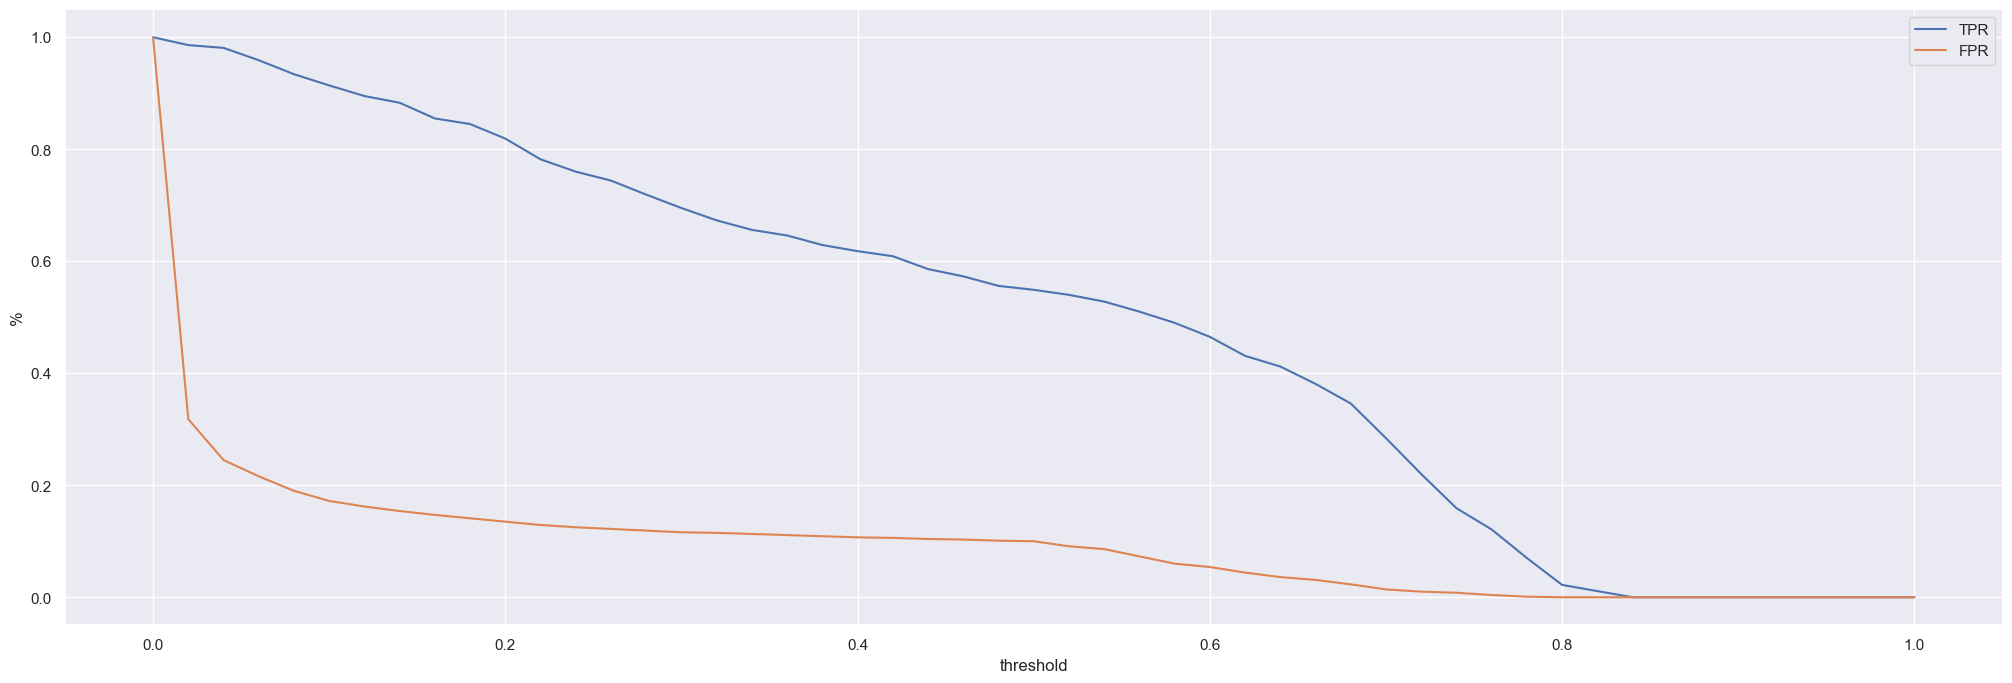

In [180]:
plt.plot(df_scor.threshold, df_scor.tpr, label='TPR')
plt.plot(df_scor.threshold, df_scor.fpr, label='FPR')
plt.xlabel("threshold")
plt.ylabel("%")
plt.legend()
plt.show()